In [0]:
import copy
import os
import pandas as pd
import math
import gzip
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns; sns.set(style="white", color_codes=True)
import json
from sklearn.metrics import mean_squared_error
%matplotlib inline
from numpy.linalg import solve

In [0]:
def parse(path):
    g = open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

df_original = getDF('Beauty_5.json')

In [0]:
df_original.head()


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1YJEY40YUW4SE,7806397051,Andrea,"[3, 4]",Very oily and creamy. Not at all what I expect...,1.0,Don't waste your money,1391040000,"01 30, 2014"
1,A60XNB876KYML,7806397051,Jessica H.,"[1, 1]",This palette was a decent price and I was look...,3.0,OK Palette!,1397779200,"04 18, 2014"
2,A3G6XNM240RMWA,7806397051,Karen,"[0, 1]",The texture of this concealer pallet is fantas...,4.0,great quality,1378425600,"09 6, 2013"
3,A1PQFP6SAJ6D80,7806397051,Norah,"[2, 2]",I really can't tell what exactly this thing is...,2.0,Do not work on my face,1386460800,"12 8, 2013"
4,A38FVHZTNQ271F,7806397051,Nova Amor,"[0, 0]","It was a little smaller than I expected, but t...",3.0,It's okay.,1382140800,"10 19, 2013"


In [0]:
df=copy.deepcopy(df_original)
df['unixReviewTime']=pd.to_datetime(df['unixReviewTime'],unit='s')
df.drop(['reviewTime'],axis=1,inplace=True)
# set unique ID for each review
df['ReviewID']=df.index+1

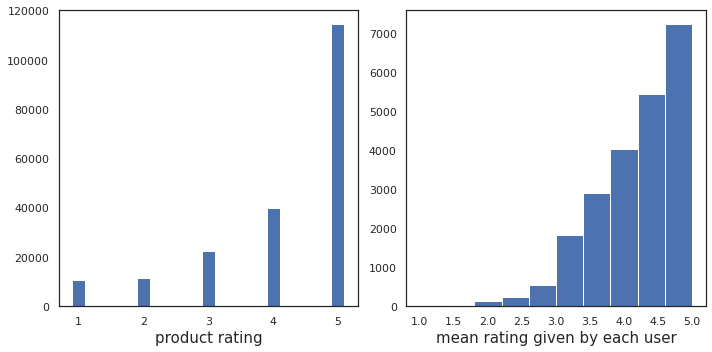

In [0]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
ax.hist(df['overall'], bins=[0.9, 1.1, 1.9, 2.1, 2.9, 3.1, 3.9, 4.1, 4.9, 5.1])
ax.set_xlabel('product rating', fontsize=15)

# mean ratings from each user
mean_rating_of_user = df.groupby('reviewerID').apply(lambda x: x['overall'].mean())
ax = fig.add_subplot(122)
ax.hist(mean_rating_of_user)
ax.set_xlabel('mean rating given by each user', fontsize=15)
plt.tight_layout()
plt.show()

In [0]:
n_users = df.reviewerID.unique().shape[0]
n_items = df.asin.unique().shape[0]
print (str(n_users) + ' users')
print (str(n_items) + ' items')

22363 users
12101 items


In [0]:
df = df.sort_values(['reviewerID', 'asin'], ascending = [True, True])
df.asin=pd.Categorical(df.asin)
df['asin_id']=df.asin.cat.codes
df.reviewerID=pd.Categorical(df.reviewerID)
df['reviewer_ID']=df.reviewerID.cat.codes

In [0]:

#check for the output of transformation to category
print ("reviewer ",pd.DataFrame(df.groupby(['reviewer_ID'])['reviewerID'].nunique()).sort_values(['reviewerID'],ascending=False).shape[0])
print ("item ", pd.DataFrame(df.groupby(['asin_id'])['asin'].nunique()).sort_values(['asin'],ascending=False).shape[0])

reviewer  22363
item  12101


In [0]:
df.head()
df_ratings=df[['reviewer_ID','asin_id','overall']]
ratings = np.zeros((n_users, n_items))

for row in df_ratings.itertuples():
    #print (row[1],row[2],row[3])
    ratings[row[1], row[2]] = row[3]
    
ratings

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [0]:
#sparsity check
sparsity = float(len(ratings.nonzero()[0]))
sparsity = (sparsity/(ratings.shape[0] * ratings.shape[1]))*100
print ('Sparsity: {:4.2f}%'.format(sparsity))

Sparsity: 0.07%


In [0]:
min_rated_items=ratings.nonzero()[0]
min_rated_items_collection={}
for i in min_rated_items:
    if i in min_rated_items_collection:
        min_rated_items_collection[i]=min_rated_items_collection[i]+1
    else:
        min_rated_items_collection[i]=1

In [0]:
user_rate_count=sorted(min_rated_items_collection.items(),key=lambda x:x[1])
print ('User rated ',user_rate_count[-1][1], 'items at the most')
print ('User rated ',user_rate_count[0][1], 'items at the least')

User rated  204 items at the most
User rated  5 items at the least


In [0]:
min_rate_by_users=ratings.nonzero()[1]
min_rate_by_users_collection={}
for i in min_rate_by_users:
    if i in min_rate_by_users_collection:
        min_rate_by_users_collection[i]=min_rate_by_users_collection[i]+1
    else:
        min_rate_by_users_collection[i]=1

In [0]:
item_rate_count=sorted(min_rate_by_users_collection.items(),key=lambda x:x[1])
print ('Item rated by ',item_rate_count[-1][1], ' users at the most')
print ('Item rated by ',item_rate_count[0][1], ' users at the least')

Item rated by  431  users at the most
Item rated by  5  users at the least


In [0]:
# set-up bins
count_bin=np.linspace(10,100,10).tolist()
count_bin.extend([5,300,500])
array_rate_count=np.array(count_bin)
array_rate_count=np.sort(array_rate_count)

In [0]:
# get the user-rated item number distribution table
def to_category(row,colname='rated_items',cate=array_rate_count):
    first_arg=np.where(cate>=row[colname])[0][0]
    if first_arg!=0:
        return "("+str(int(cate[first_arg-1]))+", "+str(int(cate[first_arg]))+"]", cate[first_arg]
    else:
        return "(, "+str(int(cate[first_arg]))+"]", cate[first_arg]

item_count=pd.DataFrame.from_dict(min_rated_items_collection,orient='index')\
.reset_index().rename(columns={'index':'userID',0: 'rated_items'})
item_count['rated_items_cat'],item_count['rated_items_num']=zip(*item_count\
                                                                .apply(to_category,cate=array_rate_count,axis=1))
pd.DataFrame(item_count.groupby(['rated_items_cat'])['userID'].count()).reset_index()

,rated_items_cat,userID
0,"(, 5]",7162
1,"(10, 20]",3106
2,"(100, 300]",17
3,"(20, 30]",655
4,"(30, 40]",231
5,"(40, 50]",97
6,"(5, 10]",10959
7,"(50, 60]",62
8,"(60, 70]",23
9,"(70, 80]",26


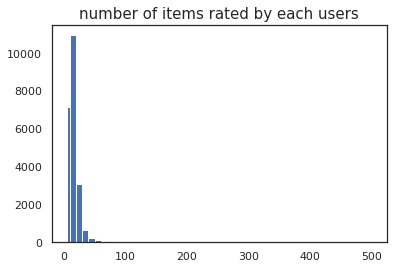

In [0]:
plt.hist(item_count['rated_items_num'],array_rate_count)
plt.title('number of items rated by each users', fontsize=15)
plt.show()

In [0]:
# get the item rated by the number of users distribution table
user_count=pd.DataFrame.from_dict(min_rate_by_users_collection,orient='index')\
.reset_index().rename(columns={'index':'itemID',0: 'rated_by_users'})
user_count['rated_by_user_cat'],user_count['rated_by_user_num']=zip(*user_count.apply(to_category,colname='rated_by_users',cate=array_rate_count,axis=1))
pd.DataFrame(user_count.groupby(['rated_by_user_cat'])['itemID'].count()).reset_index()

,rated_by_user_cat,itemID
0,"(, 5]",2181
1,"(10, 20]",2632
2,"(100, 300]",159
3,"(20, 30]",870
4,"(30, 40]",422
5,"(300, 500]",10
6,"(40, 50]",240
7,"(5, 10]",5031
8,"(50, 60]",181
9,"(60, 70]",138


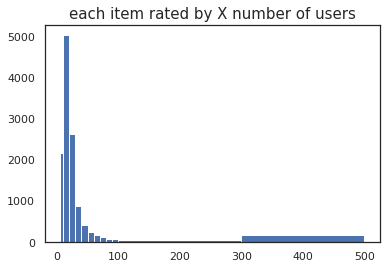

In [0]:
plt.hist(user_count['rated_by_user_num'],array_rate_count)
plt.title('each item rated by X number of users', fontsize=15)
plt.show()

In [0]:
# modify N-core to add the map between new position to old position
def apply_Ncore(ratings, N_core):
    n_users = ratings.shape[0]
    n_items = ratings.shape[1]
    items_id = [x for x in range(n_items) if len(ratings[:, x].nonzero()[0]) >= N_core]
    ratings = ratings[:, items_id]
    # map the new items position to the old
    item_link=list(zip(items_id,range(ratings.shape[1])))
    users_id = [x for x in range(n_users) if len(ratings[x, :].nonzero()[0]) >= N_core]
    # map the new user posistion to the old
    ratings = ratings[users_id, :]
    user_link=list(zip(users_id,range(ratings.shape[0])))
    return ratings,item_link,user_link

In [0]:
ratings_Ncore,items_link_Ncore,users_link_Ncore = apply_Ncore(ratings, 8)


In [0]:
print("After applying the 10-core, there are", ratings_Ncore.shape[0], "users left")
print("After applying the 10-core, there are", ratings_Ncore.shape[1], "items left")
sparsity = float(len(ratings_Ncore.nonzero()[0]))
sparsity = (sparsity/(ratings_Ncore.shape[0] * ratings_Ncore.shape[1]))*100
print ('Sparsity: {:4.2f}%'.format(sparsity))

After applying the 10-core, there are 6172 users left
After applying the 10-core, there are 7129 items left
Sparsity: 0.20%


In [0]:
df.head()


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,ReviewID,asin_id,reviewer_ID
145572,A00414041RD0BXM6WK0GX,B007IY97U0,Sarah Hale,"[0, 0]","Good quality wig, but the blonde is much more ...",3.0,Three Stars,2014-07-14,145573,9449,0
152551,A00414041RD0BXM6WK0GX,B00870XLDS,Sarah Hale,"[0, 0]",Very thin and not as long as the photos :( Aft...,2.0,( After waiting over a month to receive this w...,2014-07-14,152552,9839,0
155883,A00414041RD0BXM6WK0GX,B008MIRO88,Sarah Hale,"[0, 0]",Very thin and not as long as the photos :( Aft...,1.0,( After waiting over a month to receive this w...,2014-07-14,155884,10076,0
178477,A00414041RD0BXM6WK0GX,B00BQYYMN0,Sarah Hale,"[0, 0]","This is a great quality wig, however it is a m...",3.0,This is a great quality wig,2014-07-14,178478,11155,0
188781,A00414041RD0BXM6WK0GX,B00GRTQBTM,Sarah Hale,"[0, 0]",This is my absolute favorite wig! I have purch...,5.0,This is my absolute favorite wig! I have purch...,2014-07-14,188782,11752,0


In [0]:
df['reviewerID_Ncore']=df['reviewer_ID'].map(dict(users_link_Ncore))
df['asinID_Ncore']=df['asin_id'].map(dict(items_link_Ncore))
item_map_afterNcore=df[['asinID_Ncore','asin']].drop_duplicates(keep='first')
user_map_afterNcore=df[['reviewerID_Ncore','reviewerID']].drop_duplicates(keep='first')

In [0]:
user_map_afterNcore.loc[user_map_afterNcore['reviewerID_Ncore']==1]


,reviewerID_Ncore,reviewerID
22693,1.0,A03364251DGXSGA9PSR99


In [0]:
#check for whether the item id is linked back correctly to asin
df.loc[df['reviewerID']=='A099766128UI0NCS98N1E',['reviewerID','asin','reviewer_ID','reviewerID_Ncore','asin_id','asinID_Ncore']]

,reviewerID,asin,reviewer_ID,reviewerID_Ncore,asin_id,asinID_Ncore
3539,A099766128UI0NCS98N1E,B00008MOQE,29,4.0,184,123.0
6806,A099766128UI0NCS98N1E,B0001TOH8G,29,4.0,359,237.0
11638,A099766128UI0NCS98N1E,B0007W1R58,29,4.0,687,440.0
42136,A099766128UI0NCS98N1E,B0012UEJ1S,29,4.0,2846,1644.0
66990,A099766128UI0NCS98N1E,B001YTD3G4,29,4.0,4562,2622.0
92722,A099766128UI0NCS98N1E,B003OIPJZ6,29,4.0,6250,3599.0
93742,A099766128UI0NCS98N1E,B003RF82UK,29,4.0,6310,3636.0
103137,A099766128UI0NCS98N1E,B0048KSGZO,29,4.0,6902,4001.0
103757,A099766128UI0NCS98N1E,B004AGM47C,29,4.0,6943,NaN
104465,A099766128UI0NCS98N1E,B004BCX8B6,29,4.0,6992,4056.0


In [0]:
def train_test_split_userwise(ratings,num_test=5):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    nonzero_id=np.transpose(np.array([ratings.nonzero()[0].tolist(),ratings.nonzero()[1].tolist()]))
    index=pd.DataFrame(nonzero_id,columns=['row','col'])
    gps =index.groupby(['row'])
    randx = lambda obj: obj.loc[np.random.choice(obj.index, num_test, False),:]
    test_ratings=gps.apply(randx).values.transpose()
    test_ratings_row=test_ratings[0].tolist()
    test_ratings_col=test_ratings[1].tolist()
    train[test_ratings_row,test_ratings_col] = 0.
    test[test_ratings_row,test_ratings_col] = ratings[test_ratings_row,test_ratings_col]   
    assert(np.all((train * test) == 0)) 
    return train, test

In [0]:
train_Ncore_user, test_Ncore_user = train_test_split_userwise(ratings_Ncore,num_test=3)
# check whether the test dataset has the same shape as the training
print('training dimension: ', train_Ncore_user.shape)
print('test dimension: ',test_Ncore_user.shape)

training dimension:  (6172, 7129)
test dimension:  (6172, 7129)


In [0]:
#user-wise
def normalize_userwise(train,test):
    user=0
    train_new=copy.deepcopy(train)
    test_new=copy.deepcopy(test)
    for i in range(train_new.shape[0]):
        items=np.nonzero(train_new[i,:])[0].tolist()
        user_avg=np.sum(train_new[i,items])/len(items)
        items_test=np.nonzero(test_new[i,:])[0].tolist()
        train_new[i,items]=(train_new[i,items]-user_avg)
        test_new[i,items_test]=(test_new[i,items_test]-user_avg)
    return train_new, test_new

In [0]:
train_Ncore_user_normalized,test_Ncore_user_normalized=normalize_userwise(train_Ncore_user,test_Ncore_user)

In [0]:
# check for the output of normaization
# user for 0 in training set
user_0_trainting_sum=np.sum(train_Ncore_user_normalized[1,[x[1] for x in \
                                       list(zip(np.nonzero(train_Ncore_user_normalized)[0],\
                                            np.nonzero(train_Ncore_user_normalized)[1])) if x[0]==1]])
print ('average ratings for user 0 in training after normalization: ', user_0_trainting_sum)

# user for 0 in test set
user_0_test_sum=np.sum(test_Ncore_user_normalized[1,[x[1] for x in \
                                       list(zip(np.nonzero(test_Ncore_user_normalized)[0],\
                                            np.nonzero(test_Ncore_user_normalized)[1])) if x[0]==1]])
print ('average ratings for user 0 in test after normalization: ',user_0_test_sum)

average ratings for user 0 in training after normalization:  7.105427357601002e-15
average ratings for user 0 in test after normalization:  -2.299999999999999


In [0]:
def get_mse(pred, actual):
    pred = pred[actual.nonzero()[0].tolist(),actual.nonzero()[1].tolist()].flatten()
    actual = actual[actual.nonzero()[0].tolist(),actual.nonzero()[1].tolist()].flatten()
    mse = mean_squared_error(pred, actual)
    return mse

In [0]:
def user_baseline(train,test):
    user=0
    item_sum=0
    item_count=0
    pred=np.zeros(test.shape)
    for i in zip(np.nonzero(train)[0],np.nonzero(train)[1]):
        if i[0]==user:
            item_sum=train[i[0],i[1]]+item_sum
            item_count=item_count+1
        if i[0]>user:
            item_pos=np.nonzero(test[user,:])[0].tolist()
            pred[user,item_pos]=item_sum/item_count
            user=user+1
            item_sum=0
            item_count=0
            item_sum=train[i[0],i[1]]+item_sum
            item_count=item_count+1
    item_pos=np.nonzero(test[user,:])[0].tolist()
    pred[user,item_pos]=item_sum/item_count
    return pred

In [0]:
# baseline without normalization
# baseline MSE for Stochastic Gradient Descent
user_baseline_withoutN=user_baseline(train_Ncore_user,test_Ncore_user)
print ('baseline MSE without normalization: ', get_mse(user_baseline_withoutN,test_Ncore_user))

baseline MSE without normalization:  1.1998783713225707


In [0]:
from numpy.linalg import solve

class RecommendationALS():
    
    def __init__(self, 
                 ratings, 
                 n_factors = 10, 
                 item_reg = 0.0, 
                 user_reg = 0.0,
                 max_iter = 50,
                 verbose = True):
        """
        Train a matrix factorization model to predict empty 
        entries in a matrix. The terminology assumes a 
        ratings matrix which is ~ user x item
        
        Params
        ======
        ratings : (ndarray)
            User x Item matrix with corresponding ratings
        
        n_factors : (int)
            Number of latent factors to use in matrix 
            factorization model
        
        item_reg : (float)
            Regularization term for item latent factors
        
        user_reg : (float)
            Regularization term for user latent factors
        
        verbose : (bool)
            Whether or not to printout training progress
        """
        
        self.ratings = ratings
        self.n_users, self.n_items = ratings.shape
        self.n_factors = n_factors
        self.item_reg = item_reg
        self.user_reg = user_reg
        self._v = verbose
        self.n_iter = max_iter

    def als_step(self,
                 latent_vectors,
                 fixed_vecs,
                 ratings,
                 _lambda,
                 type = 'user'):
        """
        One of the two ALS steps. Solve for the latent vectors
        specified by type.
        """
        
        if type == 'user':
            # fix item vector and solve for the user vector
            YTY = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(YTY.shape[0]) * _lambda
            
            for u in range(latent_vectors.shape[0]):
                latent_vectors[u, :] = solve((YTY + lambdaI), ratings[u, :].dot(fixed_vecs))
            
            
        elif type == 'item':
            # fix user vector and solve for the item vector
            XTX = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(XTX.shape[0]) * _lambda
            
            for i in range(latent_vectors.shape[0]):
                latent_vectors[i, :] = solve((XTX + lambdaI), ratings[:, i].T.dot(fixed_vecs))
        return latent_vectors

    
    def fit(self):
        """ 
        Train model for n_iter iterations.
        """
        ctr = 1
        self.user_vecs = np.random.random((self.n_users, self.n_factors))
        self.item_vecs = np.random.random((self.n_items, self.n_factors))
        
        while ctr <= self.n_iter:
            if ctr % 10 == 0 and self._v:
                print ('\tcurrent iteration: {}'.format(ctr))
            
            # alternative least square
            self.user_vecs = self.als_step(self.user_vecs, 
                                           self.item_vecs, 
                                           self.ratings, 
                                           self.user_reg, 
                                           type = 'user')
            
            self.item_vecs = self.als_step(self.item_vecs, 
                                           self.user_vecs, 
                                           self.ratings, 
                                           self.item_reg, 
                                           type = 'item')
            ctr += 1
        
        
        return (self.user_vecs, self.item_vecs)
    
    def calculate_mse(self, test):
        vecs = self.fit()
        user_vecs = vecs[0]
        item_vecs = vecs[1]
        
        predictions = np.zeros((user_vecs.shape[0], item_vecs.shape[0]))
        for u in range(user_vecs.shape[0]):
            for i in range(item_vecs.shape[0]):
                predictions[u, i] = user_vecs[u, :].dot(item_vecs[i, :].T)
                
        self.train_mse = get_mse(predictions, self.ratings)
        self.test_mse = get_mse(predictions, test)
        return (self.train_mse, self.test_mse)

In [0]:
out = [ RecommendationALS(ratings = train_Ncore_user_normalized, 
                  n_factors = 20,
                  item_reg = 2.0,
                  user_reg = 2.0,
                  max_iter = x,
                  verbose = False).calculate_mse(test = test_Ncore_user_normalized) for x in [10,20,30,40,50]]

In [0]:
for i,v in enumerate([10,20,30,40,50]):
    print ("MSE on Training with ", v, " Iterations: {:4.6f}".format(out[i][0]))
    print ("MSE on Test with ", v, " Iterations: {:4.6f}".format(out[i][1]))

MSE on Training with  10  Iterations: 0.939698
MSE on Test with  10  Iterations: 1.376193
MSE on Training with  20  Iterations: 0.939458
MSE on Test with  20  Iterations: 1.376008
MSE on Training with  30  Iterations: 0.939913
MSE on Test with  30  Iterations: 1.376111
MSE on Training with  40  Iterations: 0.940201
MSE on Test with  40  Iterations: 1.376281
MSE on Training with  50  Iterations: 0.940103
MSE on Test with  50  Iterations: 1.376011


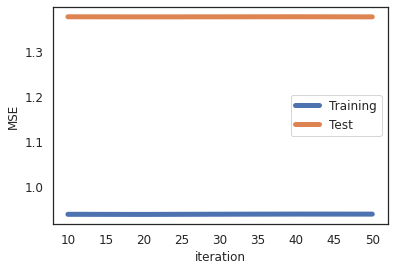

In [0]:
plt.plot([10,20,30,40,50], [i[0] for i in out], \
             label = 'Training', linewidth=5)
plt.plot([10,20,30,40,50], [i[1] for i in out], \
             label = 'Test', linewidth=5)

plt.xticks(fontsize = 12);
plt.yticks(fontsize = 12);
plt.xlabel('iteration', fontsize = 12);
plt.ylabel('MSE', fontsize = 12);
plt.legend(loc = 'best', fontsize = 12);

In [0]:
out2 = [ RecommendationALS(ratings = train_Ncore_user_normalized, 
                  n_factors = x,
                  item_reg = 2.0,
                  user_reg = 2.0,
                  max_iter = 10,
                  verbose = False).calculate_mse(test = test_Ncore_user_normalized) for x in [5,10,15,20,25]]

In [0]:
for i,v in enumerate([5,10,15,20,25]):
    print ("MSE on Training with ", v, " Latent Factors: {:4.6f}".format(out2[i][0]))
    print ("MSE on Test with ", v, " Latent Factors: {:4.6f}".format(out2[i][1]))

MSE on Training with  5  Latent Factors: 0.996620
MSE on Test with  5  Latent Factors: 1.376910
MSE on Training with  10  Latent Factors: 0.974916
MSE on Test with  10  Latent Factors: 1.376295
MSE on Training with  15  Latent Factors: 0.956239
MSE on Test with  15  Latent Factors: 1.376322
MSE on Training with  20  Latent Factors: 0.939206
MSE on Test with  20  Latent Factors: 1.376224
MSE on Training with  25  Latent Factors: 0.924268
MSE on Test with  25  Latent Factors: 1.375825


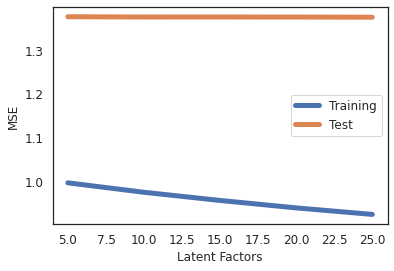

In [0]:
plt.plot([5,10,15,20,25], [i[0] for i in out2], \
             label = 'Training', linewidth=5)
plt.plot([5,10,15,20,25], [i[1] for i in out2], \
             label = 'Test', linewidth=5)

plt.xticks(fontsize = 12);
plt.yticks(fontsize = 12);
plt.xlabel('Latent Factors', fontsize = 12);
plt.ylabel('MSE', fontsize = 12);
plt.legend(loc = 'best', fontsize = 12);